# Keras tutorial - Emotion Detection in Images of Faces

Welcome to the first assignment of week 2. In this assignment, you will:
1. Learn to use Keras, a high-level neural networks API (programming framework), written in Python and capable of running on top of several lower-level frameworks including TensorFlow and CNTK. 
2. See how you can in a couple of hours build a deep learning algorithm.

#### Why are we using Keras? 

* Keras was developed to enable deep learning engineers to build and experiment with different models very quickly. 
* Just as TensorFlow is a higher-level framework than Python, Keras is an even higher-level framework and provides additional abstractions. 
* Being able to go from idea to result with the least possible delay is key to finding good models. 
* However, Keras is more restrictive than the lower-level frameworks, so there are some very complex models that you would still implement in TensorFlow rather than in Keras. 
* That being said, Keras will work fine for many common models. 

## <font color='darkblue'>Updates</font>

#### If you were working on the notebook before this update...
* The current notebook is version "v2a".
* You can find your original work saved in the notebook with the previous version name ("v2").
* To view the file directory, go to the menu "File->Open", and this will open a new tab that shows the file directory.

#### List of updates
* Changed back-story of model to "emotion detection" from "happy house."
* Cleaned/organized wording of instructions and commentary.
* Added instructions on how to set `input_shape`
* Added explanation of "objects as functions" syntax.
* Clarified explanation of variable naming convention.
* Added hints for steps 1,2,3,4

## Load packages
* In this exercise, you'll work on the "Emotion detection" model, which we'll explain below. 
* Let's load the required packages.

In [1]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from python_utils import *
# from kt_utils import *
import h5py

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

Using TensorFlow backend.


**Note**: As you can see, we've imported a lot of functions from Keras. You can use them by calling them directly in your code. Ex: `X = Input(...)` or `X = ZeroPadding2D(...)`. 

In other words, unlike TensorFlow, you don't have to create the graph and then make a separate `sess.run()` call to evaluate those variables.

## 1 - Emotion Tracking

* A nearby community health clinic is helping the local residents monitor their mental health.  
* As part of their study, they are asking volunteers to record their emotions throughout the day.
* To help the participants more easily track their emotions, you are asked to create an app that will classify their emotions based on some pictures that the volunteers will take of their facial expressions.
* As a proof-of-concept, you first train your model to detect if someone's emotion is classified as "happy" or "not happy."

To build and train this model, you have gathered pictures of some volunteers in a nearby neighborhood. The dataset is labeled.
<img src="images/face_images.png" style="width:550px;height:250px;">

Run the following code to normalize the dataset and learn about its shapes.

In [2]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_happy.h5', "r")
    train_x = np.array(train_dataset['train_set_x'][:])
    train_y = np.array(train_dataset['train_set_y'][:])

    test_dataset = h5py.File('datasets/test_happy.h5', "r")
    test_x = np.array(test_dataset['test_set_x'][:])
    test_y = np.array(test_dataset['test_set_y'][:])

    # y reshaped
    train_y = train_y.reshape((1, train_x.shape[0]))
    test_y = test_y.reshape((1, test_y.shape[0]))

    return train_x, train_y, test_x, test_y

In [3]:


X_train_orig, Y_train_orig, X_test_orig, Y_test_orig= load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


**Details of the "Face" dataset**:
- Images are of shape (64,64,3)
- Training: 600 pictures
- Test: 150 pictures

## 2 - Building a model in Keras

Keras is very good for rapid prototyping. In just a short time you will be able to build a model that achieves outstanding results.

Here is an example of a model in Keras:

```python
def model(input_shape):
    """
    input_shape: The height, width and channels as a tuple.  
        Note that this does not include the 'batch' as a dimension.
        If you have a batch like 'X_train', 
        then you can provide the input_shape using
        X_train.shape[1:]
    """
    
    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((3, 3))(X_input)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='HappyModel')
    
    return model
```

#### Variable naming convention

* Note that Keras uses a different convention with variable names than we've previously used with numpy and TensorFlow. 
* Instead of creating unique variable names for each step and each layer, such as 
```
X = ...
Z1 = ...
A1 = ...
```
* Keras re-uses and overwrites the same variable at each step:
```
X = ...
X = ...
X = ...
```
* The exception is `X_input`, which we kept separate since it's needed later.

#### Objects as functions
* Notice how there are two pairs of parentheses in each statement.  For example:
```
X = ZeroPadding2D((3, 3))(X_input)
```
* The first is a constructor call which creates an object (ZeroPadding2D).
* In Python, objects can be called as functions. Search for 'python object as function and you can read this blog post [Python Pandemonium](https://medium.com/python-pandemonium/function-as-objects-in-python-d5215e6d1b0d).  See the section titled "Objects as functions."
* The single line is equivalent to this:
```
ZP = ZeroPadding2D((3, 3)) # ZP is an object that can be called as a function
X = ZP(X_input) 
```

**Exercise**: Implement a `HappyModel()`.  
* This assignment is more open-ended than most. 
* Start by implementing a model using the architecture we suggest, and run through the rest of this assignment using that as your initial model. * Later, come back and try out other model architectures. 
* For example, you might take inspiration from the model above, but then vary the network architecture and hyperparameters however you wish. 
* You can also use other functions such as `AveragePooling2D()`, `GlobalMaxPooling2D()`, `Dropout()`. 

**Note**: Be careful with your data's shapes. Use what you've learned in the videos to make sure your convolutional, pooling and fully-connected layers are adapted to the volumes you're applying it to.

In [4]:
# GRADED FUNCTION: HappyModel

def HappyModel(input_shape):
    """
    Implementation of the HappyModel.
    
    Arguments:
    input_shape -- shape of the images of the dataset
        (height, width, channels) as a tuple.  
        Note that this does not include the 'batch' as a dimension.
        If you have a batch like 'X_train', 
        then you can provide the input_shape using
        X_train.shape[1:]
    """
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((3, 3))(X_input)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (3, 3), strides=(1, 1), name='conv0')(X)
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation('relu')(X)

    X = Conv2D(32, (3, 3), strides=(1, 1), name='conv1')(X)
    X = BatchNormalization(axis=3, name='bn1')(X)
    X = Activation('relu')(X)
    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs=X_input, outputs=X, name='HappyModel')

    ### END CODE HERE ###
    
    return model

You have now built a function to describe your model. To train and test this model, there are four steps in Keras:
1. Create the model by calling the function above  

2. Compile the model by calling `model.compile(optimizer = "...", loss = "...", metrics = ["accuracy"])`  

3. Train the model on train data by calling `model.fit(x = ..., y = ..., epochs = ..., batch_size = ...)`  

4. Test the model on test data by calling `model.evaluate(x = ..., y = ...)`  

If you want to know more about `model.compile()`, `model.fit()`, `model.evaluate()` and their arguments, refer to the official [Keras documentation](https://keras.io/models/model/).

#### Step 1: create the model.  
**Hint**:  
The `input_shape` parameter is a tuple (height, width, channels).  It excludes the batch number.  
Try `X_train.shape[1:]` as the `input_shape`.

In [5]:
### START CODE HERE ### (1 line)
happyModel = HappyModel(X_train.shape[1:])
### END CODE HERE ###

#### Step 2: compile the model

**Hint**:  
Optimizers you can try include `'adam'`, `'sgd'` or others.  See the documentation for [optimizers](https://keras.io/optimizers/)  
The "happiness detection" is a binary classification problem.  The loss function that you can use is `'binary_cross_entropy'`.  Note that `'categorical_cross_entropy'` won't work with your data set as its formatted, because the data is an array of 0 or 1 rather than two arrays (one for each category).  Documentation for [losses](https://keras.io/losses/)

In [6]:
### START CODE HERE ### (1 line)
happyModel.compile('adam','binary_crossentropy', metrics = ["accuracy"])
### END CODE HERE ###

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#### Step 3: train the model

**Hint**:  
Use the `'X_train'`, `'Y_train'` variables.  Use integers for the epochs and batch_size

**Note**: If you run `fit()` again, the `model` will continue to train with the parameters it has already learned instead of reinitializing them.

In [7]:
### START CODE HERE ### (1 line)
happyModel.fit(X_train,Y_train,batch_size=4, epochs=10)
### END CODE HERE ###


Epoch 1/10
600/600 [==============================] - 6s 9ms/step - loss: 1.0030 - accuracy: 0.7900
Epoch 2/10
600/600 [==============================] - 6s 9ms/step - loss: 0.5993 - accuracy: 0.8650
Epoch 3/10
600/600 [==============================] - 6s 9ms/step - loss: 0.2846 - accuracy: 0.9300
Epoch 4/10
600/600 [==============================] - 6s 9ms/step - loss: 0.2563 - accuracy: 0.9500
Epoch 5/10
600/600 [==============================] - 5s 9ms/step - loss: 0.2296 - accuracy: 0.9300
Epoch 6/10
600/600 [==============================] - 6s 10ms/step - loss: 0.1517 - accuracy: 0.9583
Epoch 7/10
600/600 [==============================] - 6s 10ms/step - loss: 0.0714 - accuracy: 0.9800
Epoch 8/10
600/600 [==============================] - 6s 10ms/step - loss: 0.1394 - accuracy: 0.9633
Epoch 9/10
600/600 [==============================] - 5s 9ms/step - loss: 0.1588 - accuracy: 0.9533
Epoch 10/10
600/600 [==============================] - 5s 9ms/step - loss: 0.0938 - accuracy: 0.

#### Step 4: evaluate model  
**Hint**:  
Use the `'X_test'` and `'Y_test'` variables to evaluate the model's performance.

In [8]:
### START CODE HERE ### (1 line)
preds = happyModel.evaluate(X_test,Y_test)
### END CODE HERE ###
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

150/150 [==============================] - 0s 3ms/step

Loss = 0.15672304173310597
Test Accuracy = 0.9333333373069763


#### Expected performance   
If your `happyModel()` function worked, its accuracy should be better than random guessing (50% accuracy).

To give you a point of comparison, our model gets around **95% test accuracy in 40 epochs** (and 99% train accuracy) with a mini batch size of 16 and "adam" optimizer.

#### Tips for improving your model

If you have not yet achieved a very good accuracy (>= 80%), here are some things tips:

- Use blocks of CONV->BATCHNORM->RELU such as:
```python
X = Conv2D(32, (3, 3), strides = (1, 1), name = 'conv0')(X)
X = BatchNormalization(axis = 3, name = 'bn0')(X)
X = Activation('relu')(X)
```
until your height and width dimensions are quite low and your number of channels quite large (≈32 for example).  
You can then flatten the volume and use a fully-connected layer.
- Use MAXPOOL after such blocks.  It will help you lower the dimension in height and width.
- Change your optimizer. We find 'adam' works well. 
- If you get memory issues, lower your batch_size (e.g. 12 )
- Run more epochs until you see the train accuracy no longer improves. 

**Note**: If you perform hyperparameter tuning on your model, the test set actually becomes a dev set, and your model might end up overfitting to the test (dev) set. Normally, you'll want separate dev and test sets.  The dev set is used for parameter tuning, and the test set is used once to estimate the model's performance in production.

## 3 - Conclusion

Congratulations, you have created a proof of concept for "happiness detection"!

## Key Points to remember
- Keras is a tool we recommend for rapid prototyping. It allows you to quickly try out different model architectures.
- Remember The four steps in Keras: 


1. Create  
2. Compile  
3. Fit/Train  
4. Evaluate/Test  

## 4 - Test with your own image (Optional)

Congratulations on finishing this assignment. You can now take a picture of your face and see if it can classify whether your expression is "happy" or "not happy". To do that:


1. Click on "File" in the upper bar of this notebook, then click "Open" to go on your Coursera Hub.
2. Add your image to this Jupyter Notebook's directory, in the "images" folder
3. Write your image's name in the following code
4. Run the code and check if the algorithm is right (0 is not happy, 1 is happy)!
    
The training/test sets were quite similar; for example, all the pictures were taken against the same background (since a front door camera is always mounted in the same position). This makes the problem easier, but a model trained on this data may or may not work on your own data. But feel free to give it a try! 

[[1.]]


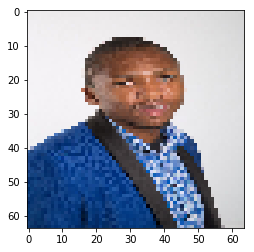

In [9]:
### START CODE HERE ###
img_path = 'images/profile_pic.png'
### END CODE HERE ###
img = image.load_img(img_path, target_size=(64, 64))
imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print(happyModel.predict(x))

## 5 - Other useful functions in Keras (Optional)

Two other basic features of Keras that you'll find useful are:
- `model.summary()`: prints the details of your layers in a table with the sizes of its inputs/outputs
- `plot_model()`: plots your graph in a nice layout. You can even save it as ".png" using SVG() if you'd like to share it on social media ;). It is saved in "File" then "Open..." in the upper bar of the notebook.

Run the following code.

In [10]:
happyModel.summary()

Model: "HappyModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 70, 70, 3)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 68, 68, 32)        896       
_________________________________________________________________
bn0 (BatchNormalization)     (None, 68, 68, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 68, 68, 32)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 66, 66, 32)        9248      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 66, 66, 32)        1

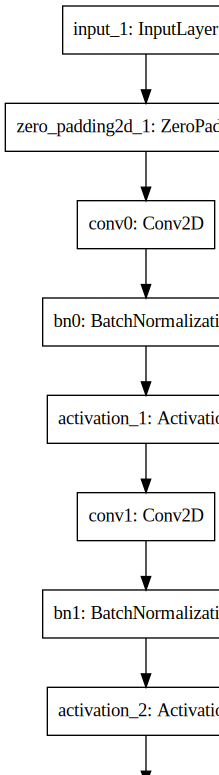

In [11]:
plot_model(happyModel, to_file='HappyModel.png')
SVG(model_to_dot(happyModel).create(prog='dot', format='svg'))